In [2]:
using LinearAlgebra
using Plots
using NLsolve
using Optim
using NonlinearSolve 
using Roots
using Distributed

In [ ]:
function ZeroMat(N::Int)
    return zeros((N,N))
end

function TrapHamiltonian(L::Int, t::Float64, v::Float64, g::Float64, pbc::Bool)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v + g*(i-L/2)*(i-L/2)
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    if pbc == true
        H[L,1] = -t
        H[1,L] = -t
    end
    return H
end

function BraggHamiltonian(L::Int, t::Float64, v::Float64, g::Float64, m::Int, q::Float64,pbc::Bool)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v + g*(i-L/2)*(i-L/2) + m *cos.(q*(i-L/2)).^2
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    if pbc == true
        H[L,1] = -t
        H[1,L] = -t
    end
    return H
end

function FreeHamiltonian(L::Int, t::Float64, v::Float64,pbc::Bool)
    """
    Writes matrix representation of spinless fermion Hamiltonian on a lattice with L sites
    and a quadratic trapping potential of strength g. 

    INPUTS
    L: number of lattice sites
    t: hopping parameter
    v: constant on-site potential
    g: trapping potential strength

    OUTPUT
    H: LxL matrix representation of non-interacting fermion Hamiltonian
    """
    H = ZeroMat(L)
    for i in range(1,L)
        H[i,i] = v 
    end
    for i in range(1,L-1)
        H[i,i+1] = -t
        H[i+1,i] = -t
    end
    if pbc == true
        H[L,1] = -t
        H[1,L] = -t
    end
    return H
end

function NCorrZeroT(N::Int, U::Matrix{Float64})
    """
    Calculate N-body correlation matrix in equilibrium at zero temperature.

    INPUTS:
    N: number of particles
    U: matrix of single-particle equilibrium eigenstates

    OUTPUTS:
    C: matrix of one-body correlations
    """
    P = U[:,1:N]
    C = P * transpose(P)
    return Symmetric(C)
end


function NCorrFiniteT(L::Int, beta::Float64, U::Matrix{Float64}, E::Vector{Float64}, mu::Float64)
    """
    Calculate N-body correlation function in equilibrium at finite temperature

    INPUTS
    L: number of sites
    beta: inverse temperature
    U: matrix of eigenvectors
    E: vector of eigenvalues
    mu: chemical potential

    OUTPUT
    C: matrix of one-body correlations
    """
    identity::Matrix{Float64} = Matrix(1.0I,L,L)
    D::Matrix{Float64} = inv(identity + Diagonal(exp.(-beta * (E - mu*ones(L)))))
    Dprime::Matrix{Float64} = U * D * transpose(U)
    # Dprime2::Matrix{Float64} = U * Dprime
    C::Matrix{Float64} = identity - Dprime
    return Symmetric(C)
end

function GetChemicalPotential(L::Int64, beta::Float64, N::Int64, U::Matrix{Float64}, E::Vector{Float64})
    """
    Get chemical potential provided N particles at temperature T

    INPUTS
    L: number of lattice sites; int
    N: number of particles; int
    beta: inverse temperature; float
    U: matrix of eigenvectors; matrix of floats
    E: list of eigenvalues; list of floats

    OUTPUT
    mu: chemical potental; float
    """
    func(mu) = sum(diag(NCorrFiniteT(L,beta,U,E,mu))) - N
    mu_guess = maximum(E[1:N])
    sol = find_zero(func,mu_guess)
    return sol
end

function pij(t::Float64,U2::Matrix{Float64},E2::Vector{Float64},C0::Matrix{Float64})
    """
    Calculate equal-time one-body density matrix at non-zero time after a quench.
    
    INPUTS
    t: time; units of hbar/J
    beta: inverse temperature; units of 1/J
    mu: chemical potential; units of J
    L: lattice sites; dimensionless
    U2: matrix of eigenvectors of post-quench Hamiltonian
    E2: vector of eigenvalues of post-quench Hamiltonian
    C0: Initial one-body correlation function, can be zero T or finite T.

    OUTPUT
    One-body correlation density matrix.
    """
    D = Diagonal(exp.(complex(0,-t)*E2))
    D1 = U2 * D * transpose(U2)
    C2 = adjoint(D1) * C0 * D1
    return Symmetric(C2)
end

function nkt(k::Float64, L::Int64, P::Matrix{Float64}, sites::Vector{Float64})
    """
    Calculate momentum distribution function at finite T and non-zero time after a quench.
    
    INPUTS
    k: quasi-momentum; units of 1/a
    L: lattice sites; dimensionless
    beta: inverse temperature; units of 1/J
    t: time; units of hbar/J
    U1: matrix of eigenvectors of pre-quench Hamiltonian
    U2: matrix of eigenvectors of post-quench Hamiltonian
    E1: vector of eigenvalues of pre-quench Hamiltonian
    E2: vector of eigenvalues of post-quench Hamiltonian
    mu: chemical potential; units of J

    OUTPUT
    Momentum distribution function
    """
    A = exp.(sites*complex(0,k))
    eik = A * transpose(conj(A)) 
    return sum(eik .* P)/L
end

nkt (generic function with 1 method)

# Spectrum

In [4]:
#################
### load data ###
#################
L::Int64 = 1000
E::Vector{Float64} = eigvals(TrapHamiltonian(L,1.0,0.1,1e-5,true))
U::Matrix{Float64} = eigvecs(TrapHamiltonian(L,1.0,0.1,1e-5,true))
E2::Vector{Float64} = eigvals(FreeHamiltonian(L,1.0,0.1,true))
U2::Matrix{Float64} = eigvecs(FreeHamiltonian(L,1.0,0.1,true))
sites::Array{Float64,1} = range(0,L-1,length=L)

0.0:1.0:999.0

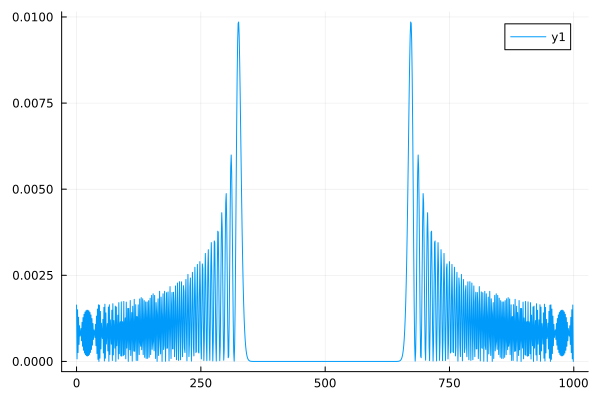

In [5]:
#################
### plot data ###
#################
plot(sites,abs.(U[:,801]).^2)

# MDF

In [17]:
#################
### load data ###
#################
L::Int64 = 1000
### pre quench ###
# E::Vector{Float64} = eigvals(TrapHamiltonian(L,1.0,0.1,1e-5,true))
# U::Matrix{Float64} = eigvecs(TrapHamiltonian(L,1.0,0.1,1e-5,true))
E::Vector{Float64} = eigvals(FreeHamiltonian(L,1.0,0.1,true))
U::Matrix{Float64} = eigvecs(FreeHamiltonian(L,1.0,0.1,true))
### post quench ###
E2::Vector{Float64} = eigvals(BraggHamiltonian(L,1.0,0.1,0.0,1000,pi/4,true))
U2::Matrix{Float64} = eigvecs(BraggHamiltonian(L,1.0,0.1,0.0,1000,pi/4,true))
sites::Array{Float64,1} = range(0,L-1,length=L);

## Zero T

  0.009005 seconds (9 allocations: 16.030 MiB, 39.56% gc time)
  0.129166 seconds (27 allocations: 91.584 MiB, 26.87% gc time)
  4.761516 seconds (36.55 k allocations: 14.955 GiB, 20.20% gc time, 0.49% compilation time)


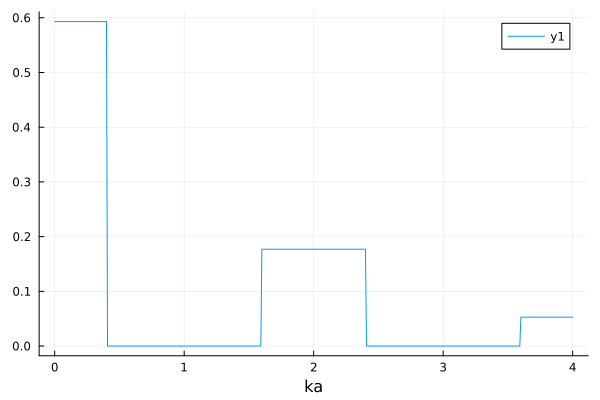

In [28]:
tpulse::Float64 = 0.002;
Np::Int64 = 101;
@time C0T::Matrix{Float64} = NCorrZeroT(Np, U);
@time p_pulse::Matrix{Float64} = real(pij(tpulse,U2,E2,C0T));
@time npulse::Vector{Float64} = real([nkt(q,L,p_pulse,sites) for q in range(0,pi,501)]);
# t::Float64 = 10.0;
# @time p::Matrix{Float64} = real(pij(t,U,E,p_pulse));
# @time n::Vector{Float64} = real([nkt(q,L,p,sites) for q in range(0,pi,501)]);
# @time n0T::Vector{Float64} = real([nkt(q,L,C0T,sites) for q in range(0,pi,501)]);
# for t in range(0,50,11)
#     p::Matrix{Float64} = real(pij(t,U,E,p_pulse));
#     n::Vector{Float64} = real([nkt(q,L,p,sites) for q in range(0,pi,501)]);
#     open(string("Bragg_quench/n_free_OBC_L=1000_N=31_t=",t,".bin"),"w") do f
#         write(f,n)
#     end
# end

plot(range(0,pi,501)/(pi/4),[npulse],
    xlabel = "ka",
)

In [14]:
# coft = real([diag(pij(t,U,E,p_pulse)) for t in range(0,10,11)])
# plot(sites,coft)

In [32]:
#################################################
### make animation of local density evolution ###
#################################################

# @gif for t ∈ range(0,2000,201)
#     plot(sites,real(diag(pij(t,U,E,p_pulse))),cbar=false,ylimits=(0,0.2))
# end every 1

## Finite T

In [48]:
# time::Float64 = 0.1;
beta::Float64 = 10.0;
# Np::Int64 = 31;
# @time mu::Float64 = GetChemicalPotential(L, beta, Np, U, E)
# @time C::Matrix{Float64} = NCorrFiniteT(L, beta, U, E, mu)
# @time p::Matrix{Float64} = real(pij(time,U2,E2,C));
# @time n::Vector{Float64} = real([nkt(q,L,p,sites) for q in range(0,pi,501)]);

tpulse::Float64 = 0.1;
Np::Int64 = 31;
@time mu::Float64 = GetChemicalPotential(L, beta, Np, U, E)
@time C::Matrix{Float64} = NCorrFiniteT(L, beta, U, E, mu)
@time p_pulse::Matrix{Float64} = real(pij(tpulse,U2,E2,C));
@time npulse::Vector{Float64} = real([nkt(q,L,p_pulse,sites) for q in range(0,pi,501)]);
t::Float64 = 30.0;
@time p::Matrix{Float64} = real(pij(t,U,E,p_pulse));
@time n::Vector{Float64} = real([nkt(q,L,p,sites) for q in range(0,pi,501)]);

  0.846840 seconds (589 allocations: 687.460 MiB, 34.39% gc time)
  0.046276 seconds (36 allocations: 53.445 MiB, 14.91% gc time)
  0.095452 seconds (27 allocations: 91.584 MiB, 3.37% gc time)
  5.486066 seconds (36.56 k allocations: 14.955 GiB, 20.46% gc time, 0.38% compilation time)
  0.112432 seconds (27 allocations: 91.584 MiB, 9.04% gc time)
  4.744329 seconds (36.55 k allocations: 14.955 GiB, 17.61% gc time, 0.47% compilation time)


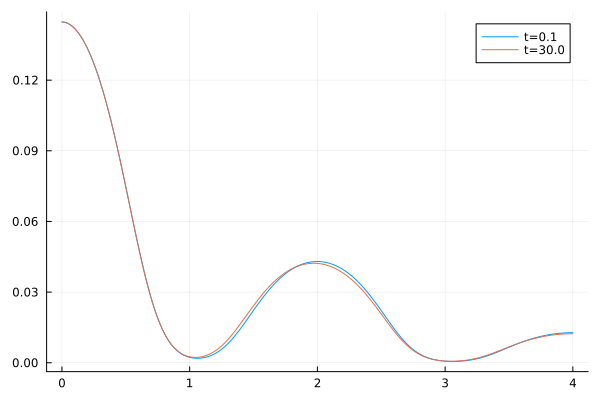

In [49]:
plot(range(0,pi,501)/(pi/4),[npulse,n],labels=["t=0.1" "t=30.0"])